## Introdução

Você foi contratado(a) para uma consultoria, e seu trabalho envolve
analisar os dados de preço do petróleo brent, que pode ser encontrado no site
do ipea. Essa base de dados histórica envolve duas colunas: data e preço (em
dólares).
Um grande cliente do segmento pediu para que a consultoria
desenvolvesse um dashboard interativo para gerar insights relevantes para
tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo
de Machine Learning para fazer o forecasting do preço do petróleo.

In [2]:
!pip install prophet
!pip install statsforecast

import pandas as pd
import numpy as np
import requests
import warnings

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from prophet import Prophet

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Coletando Dados

In [4]:
# URL da API do Ipeadata
url = "http://www.ipeadata.gov.br/api/odata4/ValoresSerie(SERCODIGO='EIA366_PBRENT366')"

# Faz a requisição para a API
response = requests.get(url)

# Verifica se a requisição foi bem-sucedida
if response.status_code == 200:
    # Converte os dados para JSON
    data = response.json()

    # Acessa os valores dentro do JSON retornado
    valores = data.get("value", [])

    # Converte para um DataFrame
    brent = pd.DataFrame(valores)

    # Verifica se há dados
    if not brent.empty:
        # Renomeia as colunas
        brent = brent.rename(columns={"VALDATA": "Data", "VALVALOR": "Preço"})

        # Converte a coluna 'Data' para o formato datetime
        brent["Data"] = pd.to_datetime(brent["Data"], errors='coerce')

        # Converte a coluna 'Preço' para formato numérico, lidando com vírgulas
        brent["Preço"] = brent["Preço"].replace(",", ".", regex=True).astype(float)

        # Garantir que a coluna 'Preço' seja numérica
        brent['Preço'] = pd.to_numeric(brent['Preço'], errors='coerce')

        # Mantém apenas as colunas 'Data' e 'Preço'
        brent = brent[["Data", "Preço"]]

        # Definindo o índice do DataFrame como 'Data'
        brent.set_index('Data', inplace=True)

        # Ordena por data (crescente ou decrescente, conforme necessário)
        brent = brent.sort_values("Data", ascending=False)

        # Preenche os valores faltantes com o preço do dia anterior
        brent['Preço'] = brent['Preço'].fillna(method='ffill')  # 'ffill' preenche com o valor anterior

        # Exibe os dados processados
        print("\nDados ajustados:")
        print(brent.head())

        # Salva em um arquivo CSV localmente
        brent.to_csv("/Users/andersonpacheco/Documents/Estudos/01 - Pós Graduacao/Tech Challenge/brent-forecast/data/raw/preco_brent.csv", index=False)
        print("\nDados salvos em 'preco_brent.csv'.")
    else:
        print("Nenhum dado válido foi encontrado na API.")
else:
    print(f"Erro ao acessar a API. Código de status: {response.status_code}")



Dados ajustados:
                           Preço
Data                            
2024-12-02 00:00:00-03:00  72.81
2024-11-29 00:00:00-03:00  74.16
2024-11-28 00:00:00-03:00  73.92
2024-11-27 00:00:00-03:00  73.91
2024-11-26 00:00:00-03:00  74.56

Dados salvos em 'preco_brent.csv'.


In [5]:
brent = brent.reset_index()
brent['Data'] = brent['Data'].astype(str)
brent['Data'] = brent['Data'].str[:10]
brent['Data'] = pd.to_datetime(brent['Data'])

brent.set_index('Data', inplace=True)

brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13582 entries, 2024-12-02 to 1986-01-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preço   13582 non-null  float64
dtypes: float64(1)
memory usage: 212.2 KB


## Análise Temporal

### Visualização Inicial dos Dados

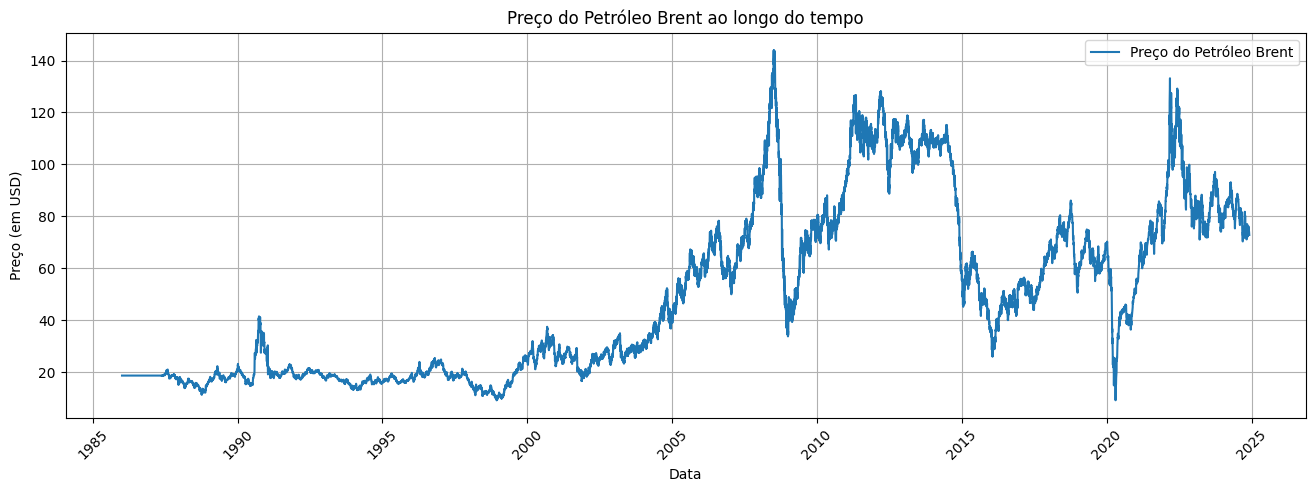

In [74]:
# Plotando os preços ao longo do tempo
plt.figure(figsize=(16, 5))
plt.plot(brent.index, brent['Preço'], label='Preço do Petróleo Brent')
plt.title('Preço do Petróleo Brent ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Preço (em USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.savefig('preco_petroleo_brent.png', bbox_inches='tight')

plt.show()

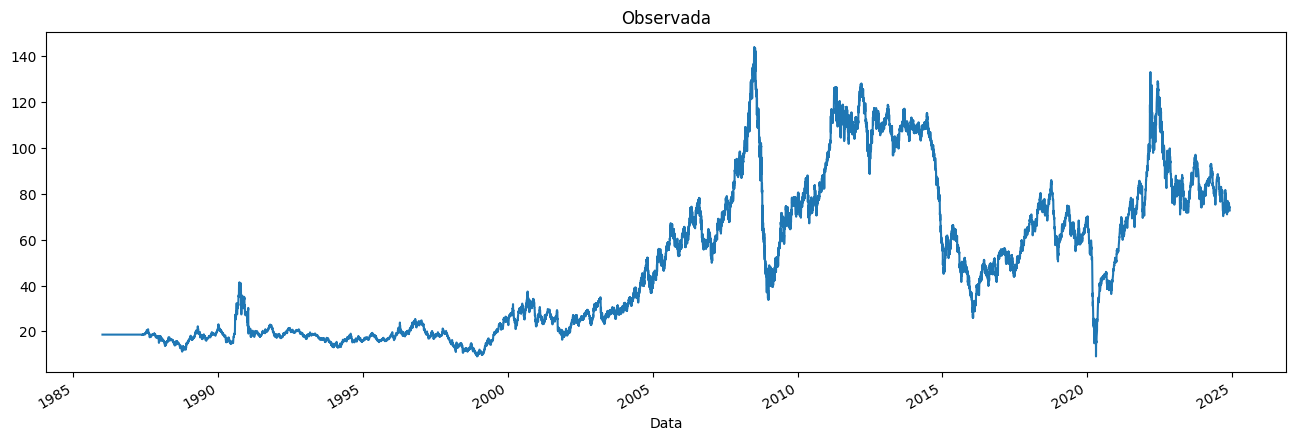

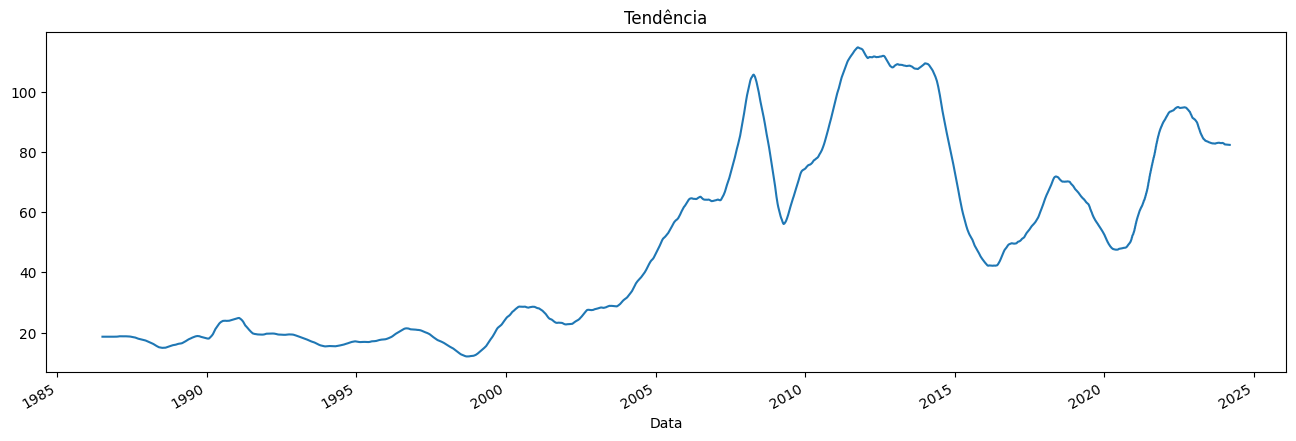

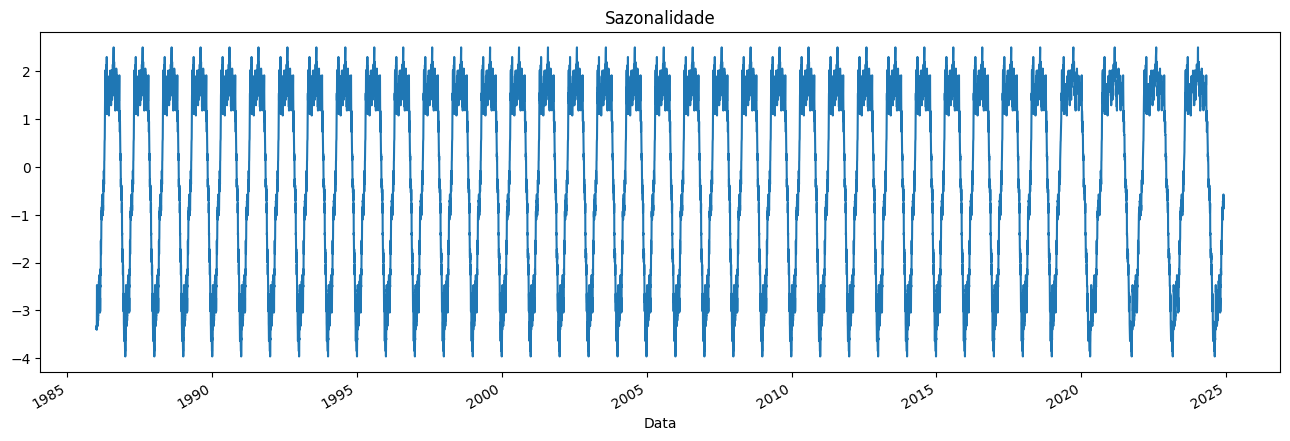

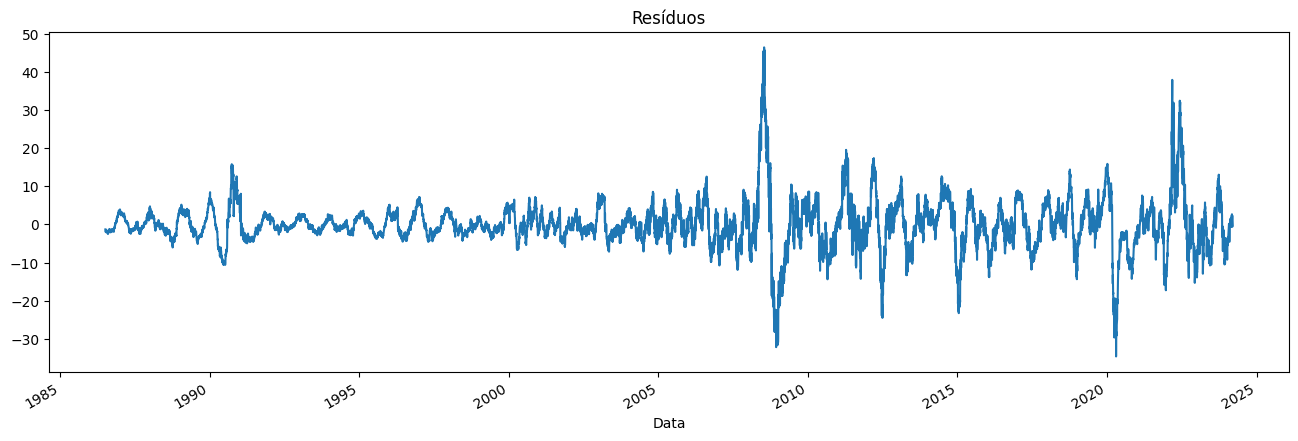

In [75]:
# Decomposição da série temporal com um período de 365 dias
decomposicao = sm.tsa.seasonal_decompose(brent['Preço'], model='additive', period=365)

# Plotando os componentes da decomposição

# Componente Observada
plt.figure(figsize=(16, 5))
decomposicao.observed.plot(title='Observada')
plt.savefig('observada.png', bbox_inches='tight')  # Salvando a imagem
plt.show()

# Componente Tendência
plt.figure(figsize=(16, 5))
decomposicao.trend.plot(title='Tendência')
plt.savefig('tendencia.png', bbox_inches='tight')  # Salvando a imagem
plt.show()

# Componente Sazonalidade
plt.figure(figsize=(16, 5))
decomposicao.seasonal.plot(title='Sazonalidade')
plt.savefig('sazonalidade.png', bbox_inches='tight')  # Salvando a imagem
plt.show()

# Componente Resíduos
plt.figure(figsize=(16, 5))
decomposicao.resid.plot(title='Resíduos')
plt.savefig('residuos.png', bbox_inches='tight')  # Salvando a imagem
plt.show()

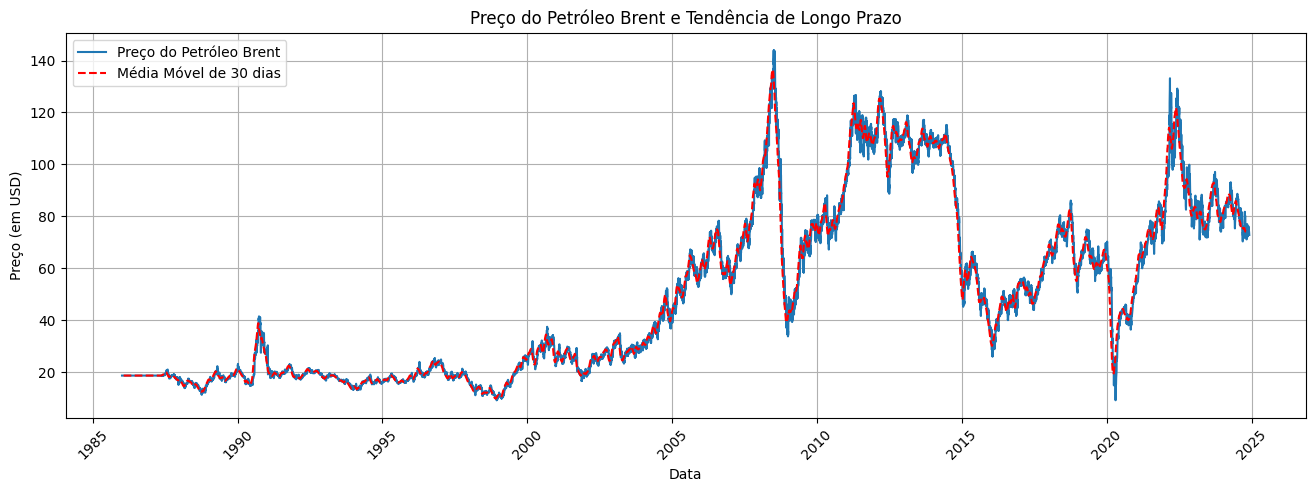

In [76]:
# Criando uma nova variável movel com os dados de brent
movel = brent.copy()

# Calculando a média móvel de 30 dias
movel['Média Móvel 30 dias'] = movel['Preço'].rolling(window=30).mean()

plt.figure(figsize=(16, 5))
plt.plot(movel['Preço'], label='Preço do Petróleo Brent')
plt.plot(movel['Média Móvel 30 dias'], label='Média Móvel de 30 dias', color='red', linestyle='--')
plt.title('Preço do Petróleo Brent e Tendência de Longo Prazo')
plt.xlabel('Data')
plt.ylabel('Preço (em USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.savefig('preco_petroleo_com_media_movel.png', bbox_inches='tight')
plt.show()

In [77]:
# Teste de Dickey-Fuller para verificar a estacionariedade
result = adfuller(brent['Preço'].dropna())

print("Estatística ADF:", result[0])
print("Valor-p:", result[1])
print("Valores críticos:", result[4])

Estatística ADF: -2.092481833182855
Valor-p: 0.24754842082470685
Valores críticos: {'1%': -3.4308329461635223, '5%': -2.861753439625795, '10%': -2.5668836090536384}


Com base no teste ADF, a série temporal não é estacionária (pois o valor-p é maior que 0.05 e a estatística ADF não ultrapassa os valores críticos).

### Removendo Estacionariedade

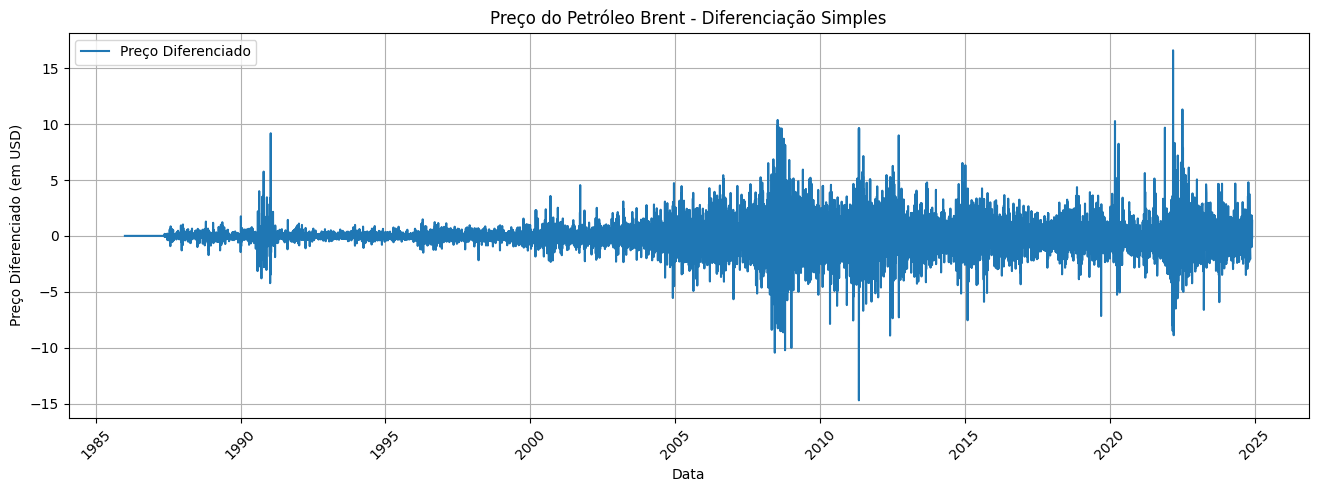

Estatística ADF: -16.017265755966957
Valor-p: 6.260680578452457e-29
Valores críticos: {'1%': -3.4308330888735523, '5%': -2.861753502691826, '10%': -2.5668836426231407}
A série é estacionária.


In [78]:
diff = brent.copy()

# Aplicando a diferenciação simples (diferenciando de 1 dia)
diff['Preço Diferenciado'] = diff['Preço'].diff()

# Removendo valores NaN criados pela diferenciação simples
diff = diff.dropna(subset=['Preço Diferenciado'])

# Plotando a série temporal após a diferenciação simples
plt.figure(figsize=(16, 5))
plt.plot(diff['Preço Diferenciado'], label='Preço Diferenciado')
plt.title('Preço do Petróleo Brent - Diferenciação Simples')
plt.xlabel('Data')
plt.ylabel('Preço Diferenciado (em USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

result = adfuller(diff['Preço Diferenciado'])
adf_stat = result[0]
p_value = result[1]
critical_values = result[4]

# Exibindo o resultado do brent ADF
print(f'Estatística ADF: {adf_stat}')
print(f'Valor-p: {p_value}')
print(f'Valores críticos: {critical_values}')

# Verificando se a série é estacionária
if p_value < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

### Análise Eventos Geopolíticos

#### Eventos Geopolíticos em Geral

In [79]:
# Eventos geopolíticos
eventos_geopoliticos = {
    "26/04/1986": "Acidente nuclear de Chernobyl (1986)",
    "16/06/1989": "Início das revoluções na Europa Oriental (1989)",
    "09/11/1989": "Queda do Muro de Berlim (1989)",
    "03/10/1990": "Reunificação da Alemanha (1990)",
    "02/08/1990": "Início da Guerra do Golfo (1990)",
    "13/09/1993": "Assinatura dos Acordos de Oslo (1993)",
    "07/04/1994": "Início do genocídio em Ruanda (1994)",
    "24/03/1999": "Início da Guerra do Kosovo (1999)",
    "11/09/2001": "Atentados de 11 de setembro (2001)",
    "20/03/2003": "Início da invasão do Iraque (2003)",
    "01/05/2004": "Ampliação da União Europeia (2004)",
    "15/09/2008": "Colapso do Lehman Brothers (marco da crise financeira) (2008)",
    "17/12/2010": "Início da Primavera Árabe (protesto na Tunísia) (2010)",
    "18/03/2014": "Anexação da Crimeia pela Rússia (2014)",
    "12/12/2015": "Adoção do Acordo de Paris sobre o Clima (2015)",
    "23/06/2016": "Referendo do Brexit (2016)",
    "09/06/2019": "Início dos protestos em Hong Kong (2019)",
    "11/03/2020": "Declaração de pandemia de COVID-19 pela OMS (2020)",
    "24/02/2022": "Início da invasão da Ucrânia pela Rússia (2022)"
}

# Convertendo as datas dos eventos para o formato de datetime
eventos_geopoliticos = {pd.to_datetime(date): event for date, event in eventos_geopoliticos.items()}

Levantamos alguns dos eventos geopoliticos mais importantes para entender se eles de alguma forma afetam o preço do Petróleo BRENT.

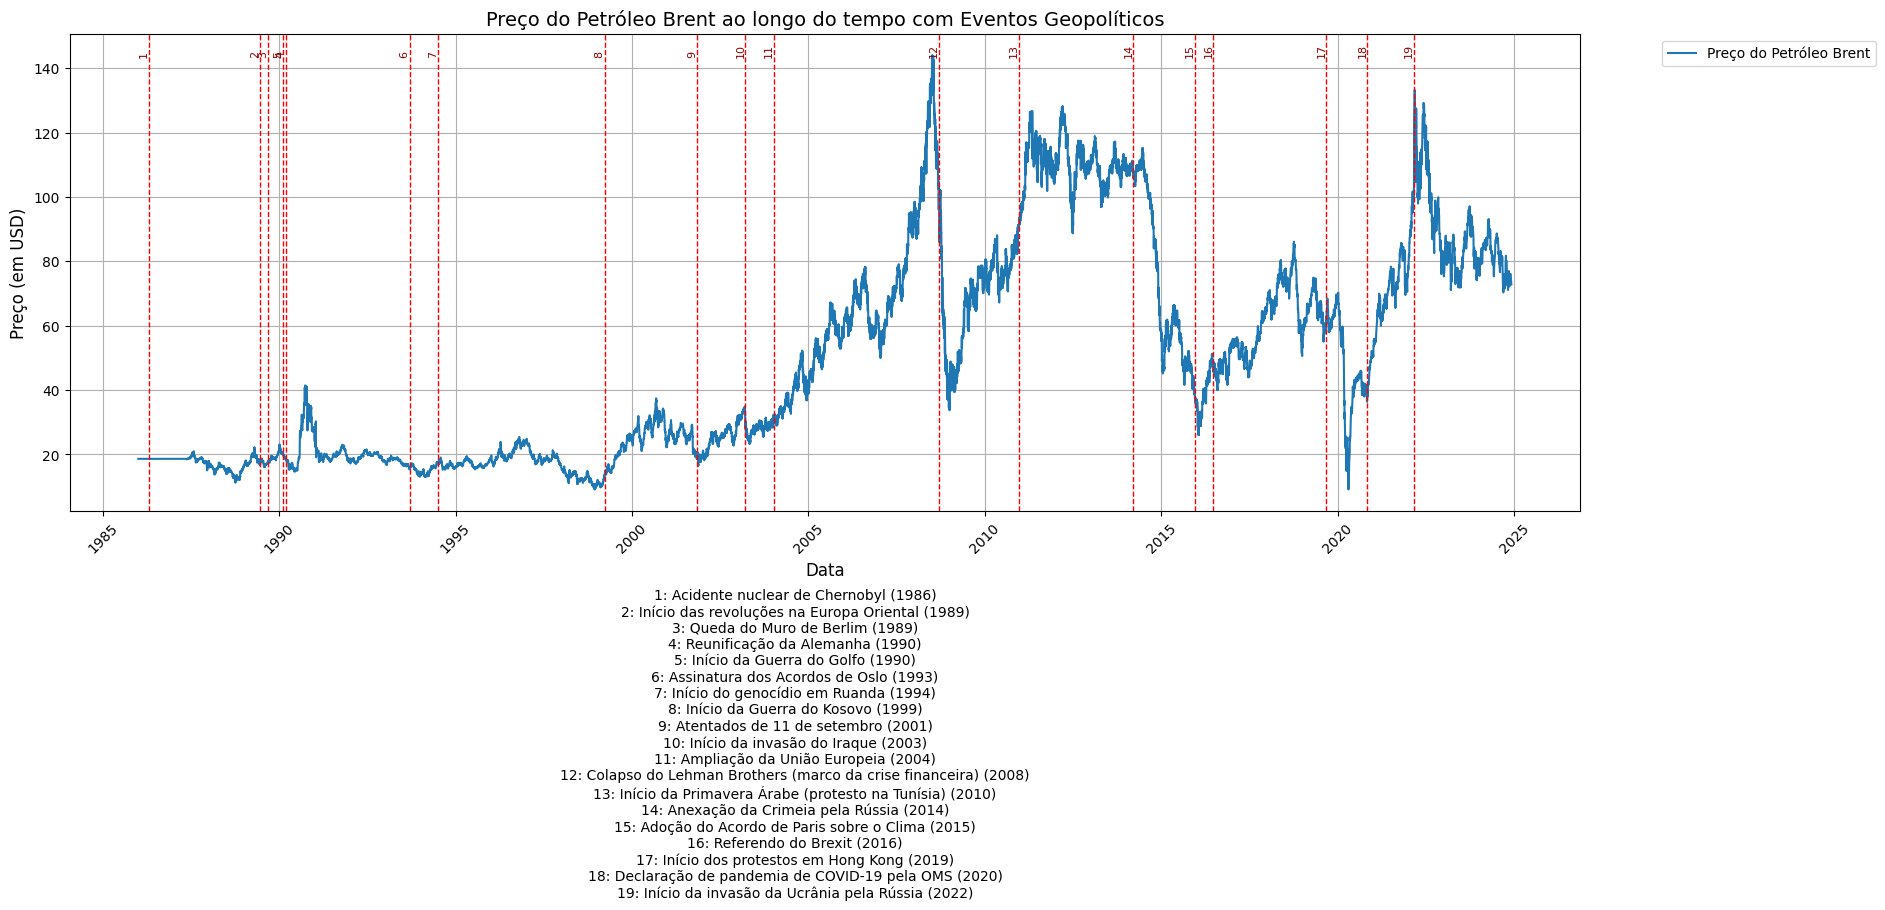

In [80]:
# Plotando os preços ao longo do tempo
plt.figure(figsize=(16, 6))
plt.plot(brent.index, brent['Preço'], label='Preço do Petróleo Brent', color='tab:blue')

# Adicionando os eventos geopolíticos com números de referência
event_reference = {}
for idx, (event_date, event_description) in enumerate(eventos_geopoliticos.items(), 1):
    plt.axvline(x=event_date, color='red', linestyle='--', lw=1)

    # Ajustando a posição do número de referência
    y_position = plt.ylim()[1] - (plt.ylim()[1] - plt.ylim()[0]) * 0.05  # Posição um pouco abaixo do topo
    plt.text(event_date, y_position, str(idx), rotation=90, ha='right', va='bottom', fontsize=8, color='darkred')

    # Guardando a descrição para a legenda com ano
    event_reference[idx] = f"{event_description}"

# Personalizando o gráfico
plt.title('Preço do Petróleo Brent ao longo do tempo com Eventos Geopolíticos', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (em USD)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustando a disposição do gráfico para evitar sobreposições

# Exibindo a legenda dos eventos abaixo do gráfico com ano
plt.figtext(0.5, 0.01, '\n'.join([f'{k}: {v}' for k, v in event_reference.items()]), ha='center', va='top', fontsize=10)

# Reposicionando a legenda do "Preço do Petróleo Brent" fora do gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

# Exibindo o gráfico
plt.savefig('preco_petroleo_brent_com_eventos_geopoliticos.png', bbox_inches='tight')
plt.show()

Ao que tudo indica confome visto no gráfico os maiores eventos geopolíticos tendem a causar grandes variações no preço, principalmente a partir dos anos 2000 onde as variações parecem ser cada vez mais expressivas.

#### Eventos Geopolíticos que afetam países produtores de Petróleo

In [81]:
eventos_petroleo = {
    "17/08/1990": "Início da Guerra do Golfo (bloqueio de exportações do Iraque) (1990)",
    "31/03/1991": "Fim da Guerra do Golfo (restabelecimento da produção de petróleo no Kuwait) (1991)",
    "11/09/2001": "Atentados de 11 de setembro (impacto no mercado global de petróleo) (2001)",
    "03/12/2001": "Criação da OPEC+ (expansão da OPEC com países produtores não membros) (2001)",
    "01/01/2008": "Crise financeira global (queda dos preços do petróleo) (2008)",
    "01/01/2011": "Início da guerra civil na Líbia (redução na produção de petróleo) (2011)",
    "03/06/2014": "Início da guerra no Iraque contra o ISIS (instabilidade nos países produtores de petróleo) (2014)",
    "27/11/2014": "OPEC decide não cortar a produção de petróleo (queda de preços) (2014)",
    "01/01/2016": "Implementação do acordo nuclear do Irã (retorno do Irã ao mercado de petróleo) (2016)",
    "12/11/2016": "OPEC anuncia corte na produção de petróleo (redução da produção em 1,2 milhão de barris/dia) (2016)",
    "22/05/2020": "Acordo de corte de produção entre OPEC+ devido à queda da demanda da COVID-19 (2020)"
}

# Convertendo as datas dos eventos para o formato datetime
eventos_petroleo = {pd.to_datetime(date): event for date, event in eventos_petroleo.items()}

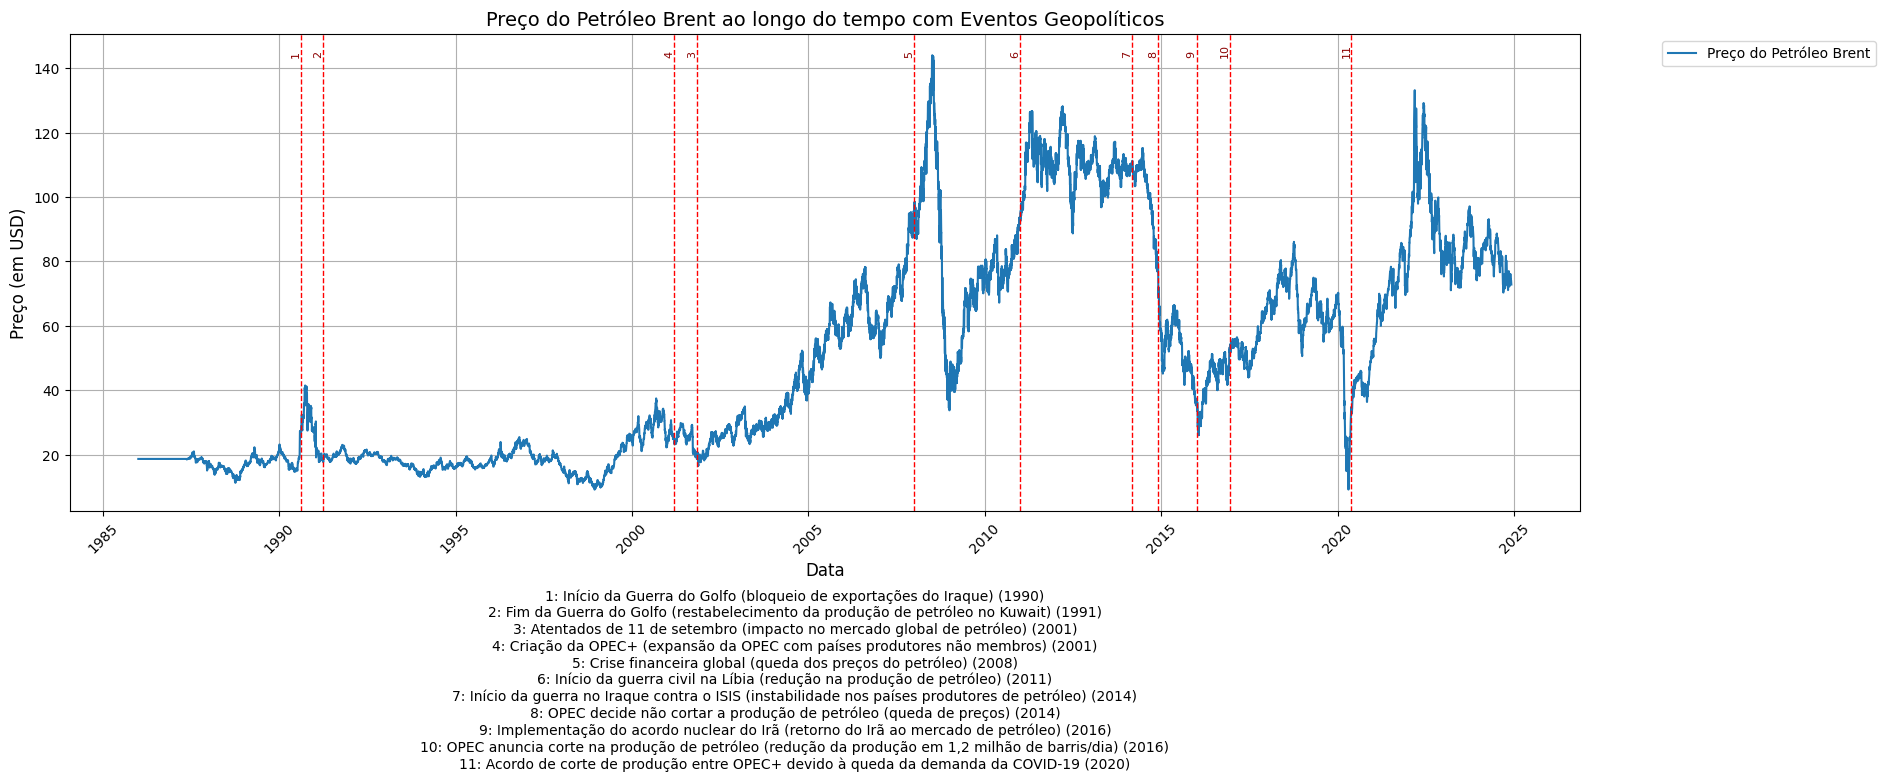

In [82]:
# Plotando os preços ao longo do tempo
plt.figure(figsize=(16, 6))
plt.plot(brent.index, brent['Preço'], label='Preço do Petróleo Brent', color='tab:blue')

# Adicionando os eventos geopolíticos com números de referência
event_reference = {}
for idx, (event_date, event_description) in enumerate(eventos_petroleo.items(), 1):
    plt.axvline(x=event_date, color='red', linestyle='--', lw=1)

    # Ajustando a posição do número de referência
    y_position = plt.ylim()[1] - (plt.ylim()[1] - plt.ylim()[0]) * 0.05  # Posição um pouco abaixo do topo
    plt.text(event_date, y_position, str(idx), rotation=90, ha='right', va='bottom', fontsize=8, color='darkred')

    # Guardando a descrição para a legenda com ano
    event_reference[idx] = f"{event_description}"

# Personalizando o gráfico
plt.title('Preço do Petróleo Brent ao longo do tempo com Eventos Geopolíticos', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (em USD)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustando a disposição do gráfico para evitar sobreposições

# Exibindo a legenda dos eventos abaixo do gráfico com ano
plt.figtext(0.5, 0.01, '\n'.join([f'{k}: {v}' for k, v in event_reference.items()]), ha='center', va='top', fontsize=10)

# Reposicionando a legenda do "Preço do Petróleo Brent" fora do gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

# Exibindo o gráfico
plt.savefig('preco_petroleo_brent_com_eventos_produtores.png', bbox_inches='tight')
plt.show()

Esses eventos geopolíticos que afetam diretamente os países produtores de petróleo são ainda melhores para indicar variações nos preços do Petróleo

## Train Test Split

In [83]:
# Filtrando os dados a partir de 2018 com base no índice 'Data'
diff = diff[diff.index >= '2018-01-01']

diff.sort_index(inplace=True)

# Filtrar os 30 últimos dias para os dados de teste
test_size = 30
train = diff.iloc[:-test_size]
test = diff.iloc[-test_size:]

print(f"Tamanho do treino: {len(train)}")
print(f"Tamanho do teste (últimos 30 dias): {len(test)}")
print(f"Tamanho total: {len(train) + len(test)}")

Tamanho do treino: 1868
Tamanho do teste (últimos 30 dias): 30
Tamanho total: 1898


## Modelo Naive

### Previsão

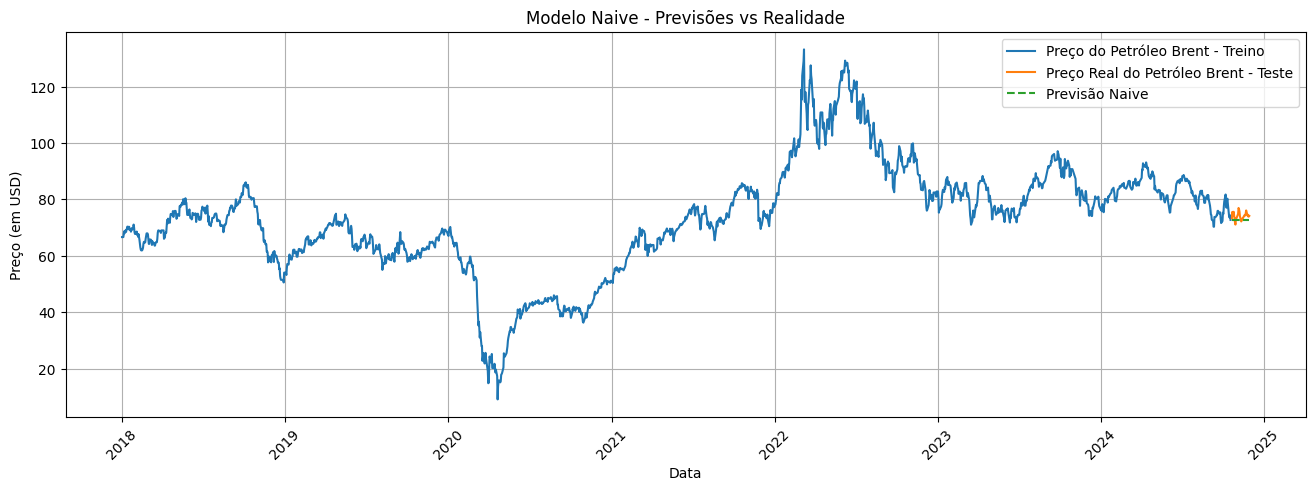

In [84]:
# Modelo Naive: A previsão para cada ponto no conjunto de teste será o valor do último ponto de treino
naive_predictions = np.repeat(train['Preço'].iloc[-1], len(test))

# Visualizando a previsão do modelo Naive
plt.figure(figsize=(16, 5))
plt.plot(train.index, train['Preço'], label='Preço do Petróleo Brent - Treino')
plt.plot(test.index, test['Preço'], label='Preço Real do Petróleo Brent - Teste')
plt.plot(test.index, naive_predictions, label='Previsão Naive', linestyle='--')
plt.title('Modelo Naive - Previsões vs Realidade')
plt.xlabel('Data')
plt.ylabel('Preço (em USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Métricas de Erro

In [85]:
# Calculando as métricas de erro (MSE e MAE)
mse_naive = mean_squared_error(test['Preço'], naive_predictions)
mae_naive = mean_absolute_error(test['Preço'], naive_predictions)

print(f"MSE (Erro Quadrático Médio) do Modelo Naive: {mse_naive:.2f}")
print(f"MAE (Erro Absoluto Médio) do Modelo Naive: {mae_naive:.2f}")

MSE (Erro Quadrático Médio) do Modelo Naive: 3.68
MAE (Erro Absoluto Médio) do Modelo Naive: 1.61


O modelo Naive, que utiliza o valor mais recente como previsão para os próximos períodos, apresenta um desempenho inicial de referência. Embora o erro absoluto médio (MAE) seja relativamente baixo, sugerindo que o modelo não está completamente fora de sintonia, o MSE indica que ele sofre com erros maiores devido a sua simplicidade e incapacidade de capturar tendências ou padrões temporais no preço do Brent.

## Modelo Auto Arima

### Previsão

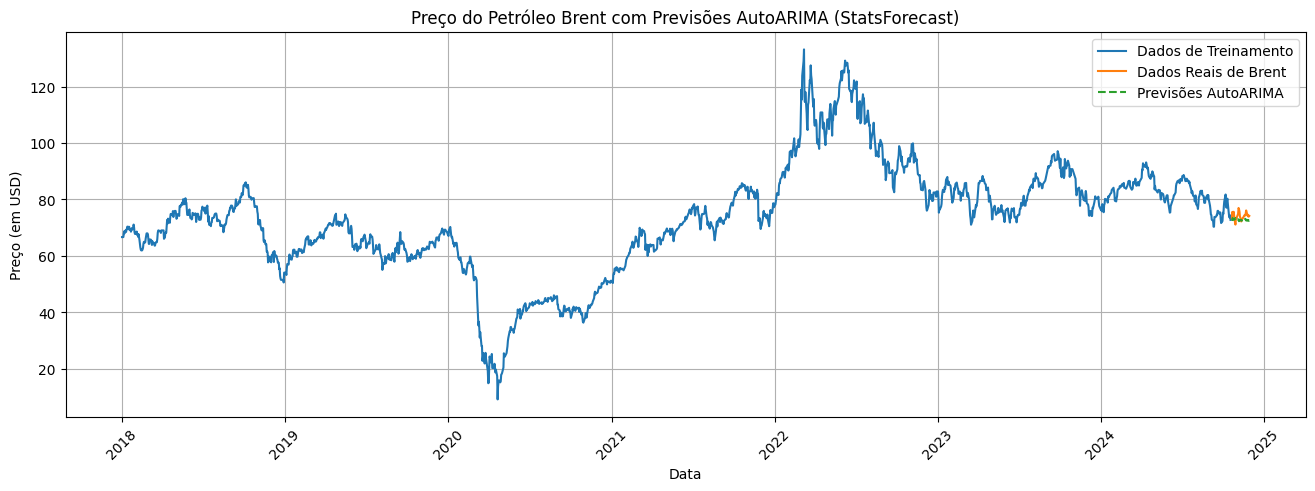

In [86]:
train_data = train[['Preço']].reset_index()  # Ajustando para garantir que a data está na coluna
train_data.columns = ['ds', 'y']  # Renomeando as colunas para 'ds' (data) e 'y' (valores)
train_data['unique_id'] = 'brent'
train_data = train_data[['unique_id', 'ds', 'y']]

AutoArima = StatsForecast(
    models=[AutoARIMA(season_length=7)],
    freq='D',
    n_jobs=-1
)

# Ajustando o modelo com os dados de treino
AutoArima.fit(train_data)

# Fazendo previsões para os 30 últimos dias
predictions = AutoArima.predict(h=len(test))
predicted_values = predictions['AutoARIMA'].values[:len(test)]

# Visualizando as previsões e os dados reais
plt.figure(figsize=(16, 5))
plt.plot(train.index, train['Preço'], label='Dados de Treinamento')
plt.plot(test.index, test['Preço'], label='Dados Reais de Brent')
plt.plot(test.index, predicted_values, label='Previsões AutoARIMA', linestyle='--')
plt.title('Preço do Petróleo Brent com Previsões AutoARIMA (StatsForecast)')
plt.xlabel('Data')
plt.ylabel('Preço (em USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Métricas de Erro

In [87]:
mse_auto_arima = mean_squared_error(test['Preço'], predicted_values)
mae_auto_arima = mean_absolute_error(test['Preço'], predicted_values)

print(f"MSE (Erro Quadrático Médio) do Modelo AutoARIMA: {mse_auto_arima:.2f}")
print(f"MAE (Erro Absoluto Médio) do Modelo AutoARIMA: {mae_auto_arima:.2f}")

MSE (Erro Quadrático Médio) do Modelo AutoARIMA: 3.90
MAE (Erro Absoluto Médio) do Modelo AutoARIMA: 1.60


Comparado ao Naive, o AutoARIMA apresenta uma pequena melhora no MAE, mostrando que ele consegue capturar variações no preço com mais precisão média. No entanto, o MSE é ligeiramente maior, indicando que, embora seja mais preciso em média, ele ainda pode ser afetado por grandes erros esporádicos. Isso pode ser explicado por limitações na identificação de sazonalidade ou tendências em um horizonte curto.

Destaque: O AutoARIMA é um avanço em relação ao Naive, pois incorpora análise de tendências e sazonalidade, mas a melhoria em termos de erro médio é marginal.

## Modelo Prophet

### Previsão

In [88]:
df_prophet = diff.copy()
df_prophet_reset = df_prophet.reset_index()

# Renomear as colunas para 'ds' (data) e 'y' (preço)
df_prophet_ready = df_prophet_reset.rename(columns={'Data': 'ds', 'Preço': 'y'})

# Inicializar o modelo Prophet
model = Prophet()

# Ajustar o modelo com os dados
model.fit(df_prophet_ready)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxb71avbo/kx9kmx5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxb71avbo/da23l57v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57439', 'data', 'file=/tmp/tmpxb71avbo/kx9kmx5n.json', 'init=/tmp/tmpxb71avbo/da23l57v.json', 'output', 'file=/tmp/tmpxb71avbo/prophet_modelxzsti6au/prophet_model-20241206155845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


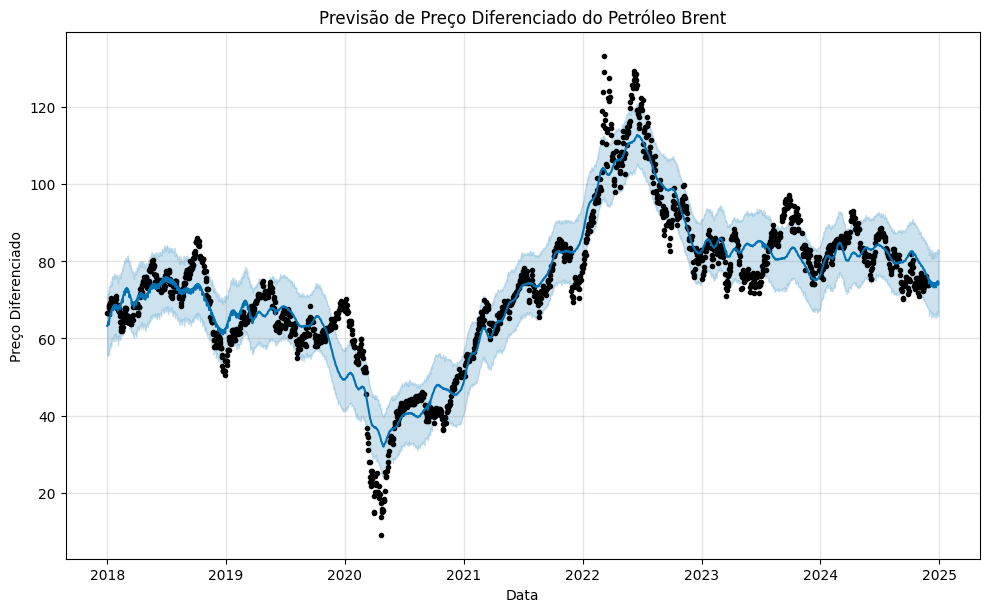

In [89]:
# Criar o dataframe futuro com base nos dados de treino
future = model.make_future_dataframe(periods=30, freq='D')

# Fazer previsões com os dados futuros
forecast = model.predict(future)

# Exibir as previsões
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

model.plot(forecast)
plt.title("Previsão de Preço Diferenciado do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Preço Diferenciado")
plt.show()

### Métricas de Erro

In [90]:
# Avaliando a precisão do modelo usando MSE e MAE
forecast_values = forecast['yhat'][-len(test):].values  # Previsões para o período de teste
real_values = test['Preço'].values  # Valores reais do conjunto de teste

# Calculando as métricas de erro
mse_prophet = mean_squared_error(real_values, forecast_values)
mae_prophet = mean_absolute_error(real_values, forecast_values)

print(f'MSE (Erro Quadrático Médio) do Modelo Prophet: {mse_prophet:.2f}')
print(f'MAE (Erro Absoluto Médio) do Modelo Prophet: {mae_prophet:.2f}')

MSE (Erro Quadrático Médio) do Modelo Prophet: 1.84
MAE (Erro Absoluto Médio) do Modelo Prophet: 1.05


O modelo Prophet demonstra uma melhora significativa em ambas as métricas quando comparado ao AutoARIMA e ao Naive. A redução de mais de 50% no MSE em relação ao AutoARIMA indica que ele é menos suscetível a erros extremos. Além disso, o menor MAE (1.05) reflete um desempenho mais consistente e uma capacidade superior de captar padrões e tendências no conjunto de dados.

O Prophet supera os modelos anteriores, especialmente na redução de grandes erros, tornando-o o mais indicado para previsão de preços do petróleo Brent entre as opções avaliadas.